#### Goal of this script is to:
####  2| make new anova df for each participant 

In [1]:
# load packages
import numpy as np 
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime

In [2]:
NumBins = 6 # number of contrasts
NumHarms = 4 # number of harmonic data: 2F1, 4F1
NumConds = 4

nb = NumBins # makes plotting easier
pe = 0
po = 1

In [3]:
cp1 = sns.color_palette("husl", 8) # color pallete 1 
cp2 = sns.color_palette("Paired", 12)  # color pallete 2
sns.set_theme() # set global plot theme
x_lev = np.arange(0,NumBins,1) # x ticks for plotting

In [4]:
# Main Directory of processed file from MatLab
# MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir
MainDir = 'C:\\plimon\\LTP_analysis\\RCA_F1\\CleanCRFDiff\\' # set dir
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Files on hand: {d}')
##############################################
FileN = d[0] # choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Files on hand: ['2468F_clean_20240403_2247.pkl', 'AllClean_CRF_Diffs_2468F_clean_20240403_2246.pkl']
Current WD: C:\plimon\LTP_analysis\RCA_F1\CleanCRFDiff\2468F_clean_20240403_2247.pkl
Does File #1 Exist? True


In [5]:
def FixSaturation(NumBins,NumHarms,x):
    """
    Imports Original, Clean Contrast Response Functions 
    and fixes Supersaturation that occurs at high contrasts
    by finding the max amp if it is not at the highest contrast 
    and sets the remaining contrast responses to the max max amplitude
    dataIn = np.array, 3 dims: [subs  x  contrast responses per numharm  x   pre/post]
    """
    d = np.zeros_like((x)) # store clean data in same format
    d1,d2,d3  = x.shape # get dims for smooth iterating
    pos_rec = [] # list to save where max response was found 

    for sIn in range(d1): # acess 1 subs data 
        dataIn = x[sIn,:,:] # [12 x 2]
        for j in range(NumHarms): # access harmonic data indicies (contrast(NumBins)-dependent)
            start = (j)+((NumBins-1)*j)
            end =  ((j+1)*NumBins)
            for cond in range(2): # access pre and post crf's
                #print(f'[{sIn},{start}:{end},{cond}]')
                respIn = dataIn[start:end,cond] # data array 
                dataOut = np.zeros_like((respIn)) # empty to fill w fixed supersaturation
                maxpos = np.argmax(respIn) # find max pos
                pos_rec.append(maxpos)
                maxamp = respIn[maxpos] # find val of max pos
                if maxpos < NumBins: # if max pos is not at highest contrast, 
                    dataOut[:maxpos] =  respIn[:maxpos] # keep data until premature max response occurs
                    dataOut[maxpos:] = maxamp # fill remaining elements with that set max response 

                    d[sIn,start:end,cond] = dataOut # save this array in empty array
                else:
                    d[sIn,start:end,cond]  = respIn # or keep data the same if crf max response was at NumBins(highest contrast)
    return d, pos_rec

In [6]:
loadData = pkl.load(open(file_path1,'rb'))
print(loadData.keys())

dict_keys(['SubjNames', 'DiffData', 'PPData', 'Avg', 'ErrorBars', 'DiffAvg', 'DiffErrorBars', 'VoiceMemo', 'DictMainKeys', 'ContLevs', 'crfLabs'])


In [7]:
diff_data = loadData['DiffData'] # post - pre crf difference data per subj per condition per harmonic
diff_eb = loadData['DiffErrorBars']

pp_data = loadData['PPData'] # pre post data 
acrf = loadData['Avg']
eb = loadData['ErrorBars']

data_labels = ['AttnL F1, attended','AttnL F2, ~attended','AttnR F1, ~attended','AttnR F2, attended']
contrast_levels = loadData['ContLevs'] # array for contrast labels (indexing)
contrast_labs = loadData['crfLabs'] # list for contrast labels (plotting)
note = loadData['VoiceMemo'] # personal note
print(note)
H_labs = ['2','4','6','8']
coSubNames = loadData['SubjNames']

['This data contains clean,processed (post-pre) contrast response function differences for each condition']


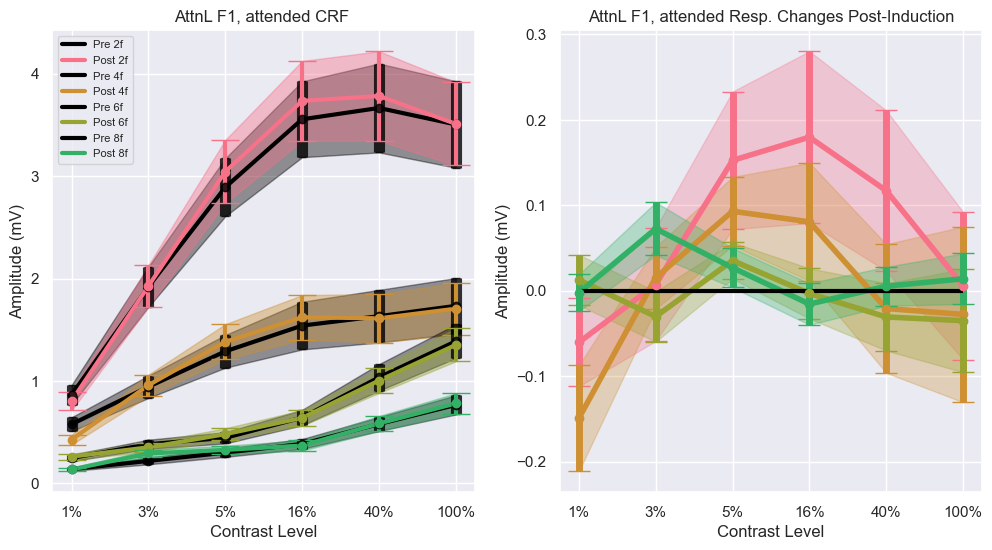

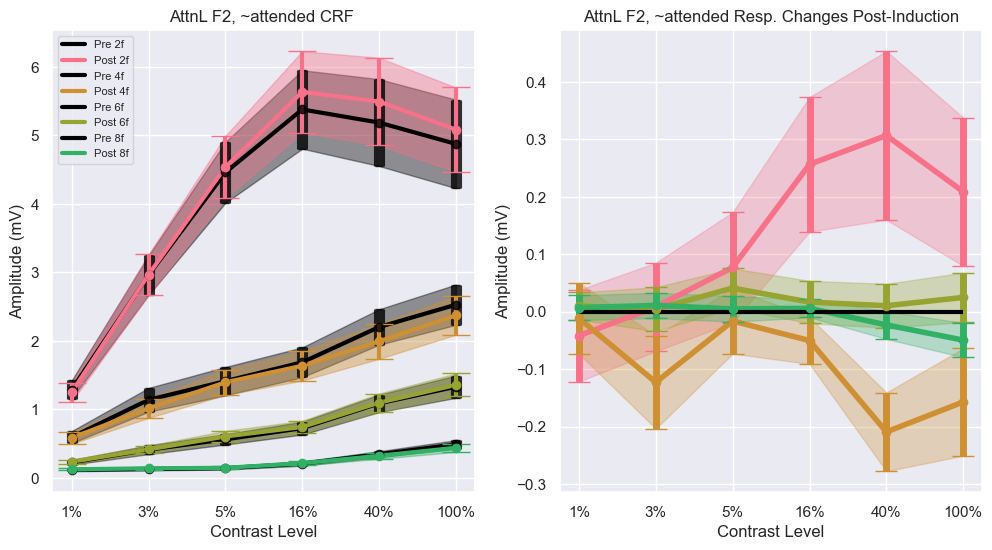

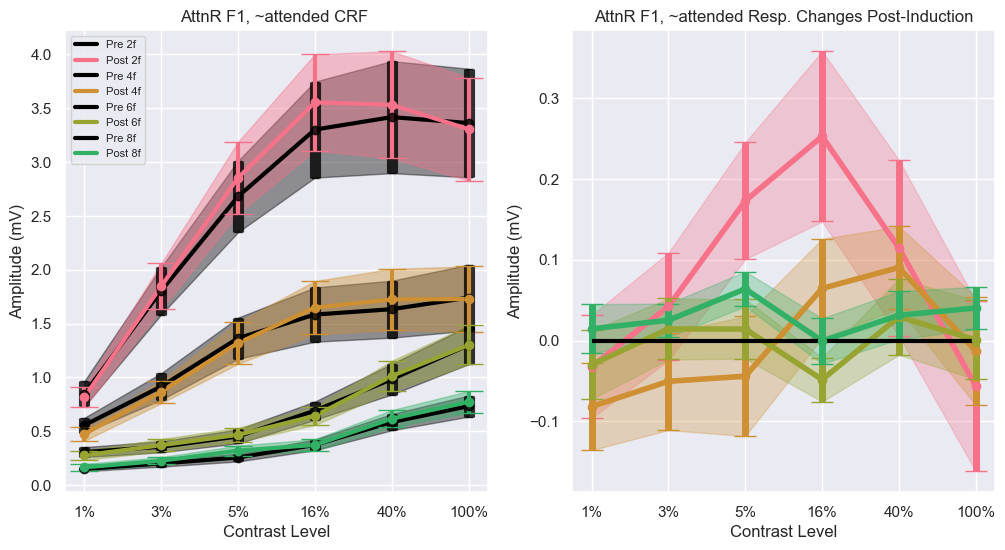

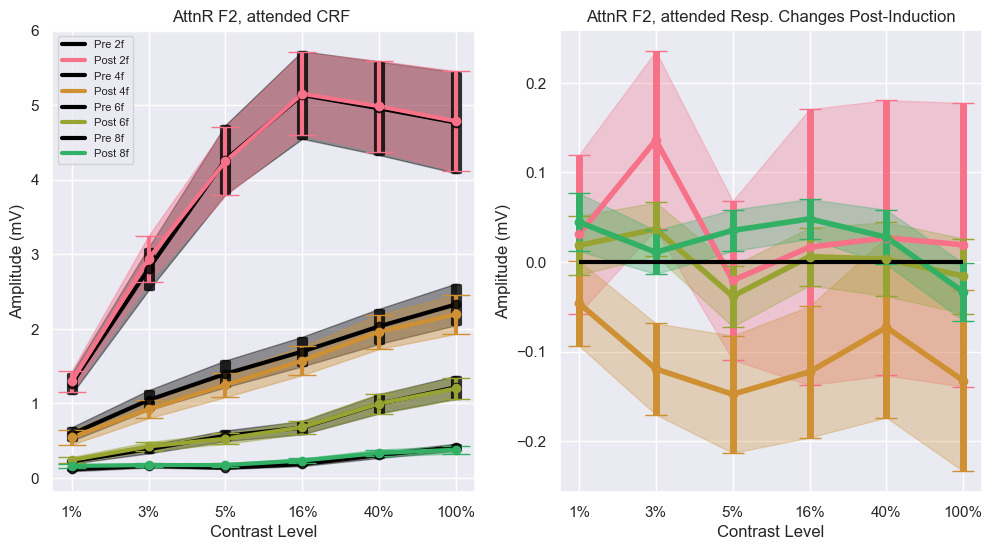

In [8]:
for co in range(NumConds):
     data = pp_data[co] # 3d [subj x contasts x pre post]
     [ns,nc,nh] = data.shape
     m_pre = np.mean(data[:,:,0],axis = 0,) # 24 array
     m_post = np.mean(data[:,:,1],axis = 0)
     # error bars for post-pre sweep responses
     eb = np.zeros((NumHarms*NumBins,2)) # error bars for pre and post crfs
     for pp in range(2):
          contrastMean = np.mean(data[:,:,pp], axis = 0) # mean across sweeps
          std = np.std(data[:,:,pp],axis = 0) # std across sweeps
          err_bar = std/np.sqrt(ns) # erorr  bar cals
          eb[:,pp] = err_bar # add array to errorbarr array
     ###################################################################
     dd = diff_data[co] # 2d [subj x rpost-pre response differences]
     # error bars for post-pre sweep response differences 
     m_dd = np.mean(dd,axis = 0) # mean of post-pre differences
     std_dd = np.std(dd, axis = 0) # std
     rdeb = std_dd/np.sqrt(ns) # response data error bars
     h_lab = ['2f','4f','6f','8f'] # harmonic labels ! 
     fig,axs = plt.subplots(1,2, figsize = (12,6), sharey = False)
     # plot fig # 1 
     for hi in range(NumHarms): # -1 to run less harmonic data
          s = 0 + (NumBins*hi)
          e = (s + NumBins)
          #print(f'{s,e}')
          # plot pre and post crf data
          axs[0].plot(m_pre[s:e], color = 'black', label = f'Pre {h_lab[hi]}', linewidth = 3)
          axs[0].errorbar(np.arange(NumBins),m_pre[s:e],eb[s:e,0],fmt = 'o',color = 'black', linewidth = 3, elinewidth = 8, capsize = 3, alpha = 0.8)
          axs[0].fill_between(np.arange(NumBins), m_pre[s:e] - eb[s:e,0], m_pre[s:e] + eb[s:e,0], color = 'black', alpha=0.4)

          axs[0].plot(m_post[s:e], color = cp1[hi],label = f'Post {h_lab[hi]}', linewidth = 3)
          axs[0].errorbar(np.arange(NumBins),m_post[s:e],eb[s:e,1],fmt = 'o',color = cp1[hi], linewidth = 4, elinewidth = 3, capsize = 10)
          axs[0].fill_between(np.arange(NumBins), m_post[s:e] - eb[s:e,1], m_post[s:e] + eb[s:e,1], color = cp1[hi], alpha=0.4)
     # ############ # plot fig # 2 , plot difference data now
          axs[1].plot(m_dd[s:e], color = cp1[hi], linewidth = 4)
          axs[1].errorbar(np.arange(NumBins), m_dd[s:e],rdeb[s:e],fmt = 'o', color = cp1[hi], linewidth = 9, elinewidth = 5, capsize = 8)
          axs[1].fill_between(np.arange(NumBins), m_dd[s:e] - rdeb[s:e], m_dd[s:e] + rdeb[s:e], color = cp1[hi], alpha=0.3)
          if hi == 3: # plt legend once 
               axs[0].legend(loc = 'upper left', fontsize = 8)
     axs[1].hlines(0, xmin = 0, xmax = 5, color = 'black', linewidth = 3)

     axs[0].set_title(f'{data_labels[co]} CRF ')
     axs[0].set_xticks(ticks = np.arange(NumBins),labels = contrast_labs)
     axs[0].set_xlabel('Contrast Level')
     axs[0].set_ylabel('Amplitude (mV)')

     axs[1].set_title(f'{data_labels[co]} Resp. Changes Post-Induction')
     axs[1].set_xticks(ticks = np.arange(NumBins),labels = contrast_labs)
     axs[1].set_xlabel('Contrast Level')
     axs[1].set_ylabel('Amplitude (mV)')

## Fix Supersaturation and Visualize

# make data array into data frame try for post - pre and for diffs too

In [9]:
CorrectedCRF = {} # save fied supersaturation in the same format as origina crf
max_amp_rec = {} # save position where supersaturation occured

for co in range(NumConds):
    CorrectedCRF[co], max_amp_rec[co] = FixSaturation(NumBins,NumHarms,pp_data[co])

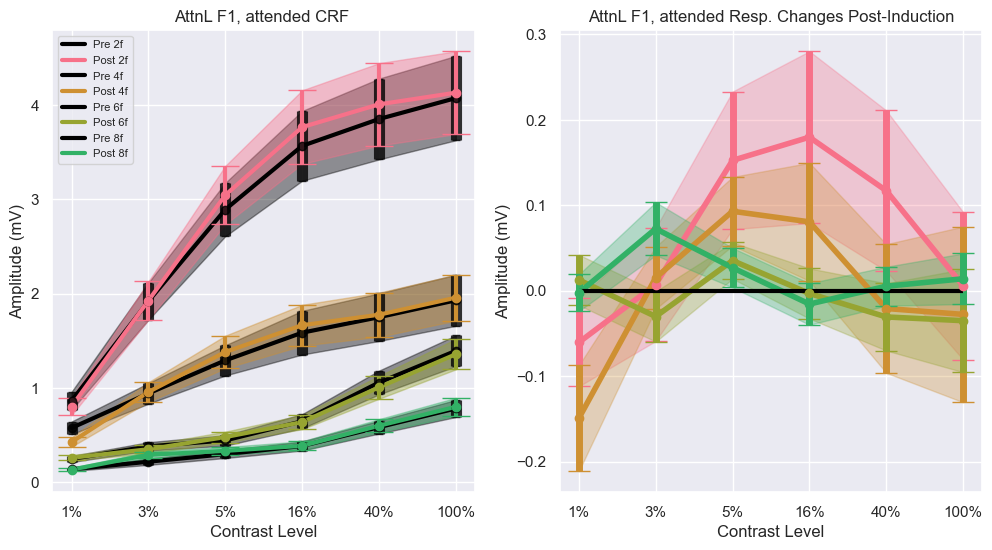

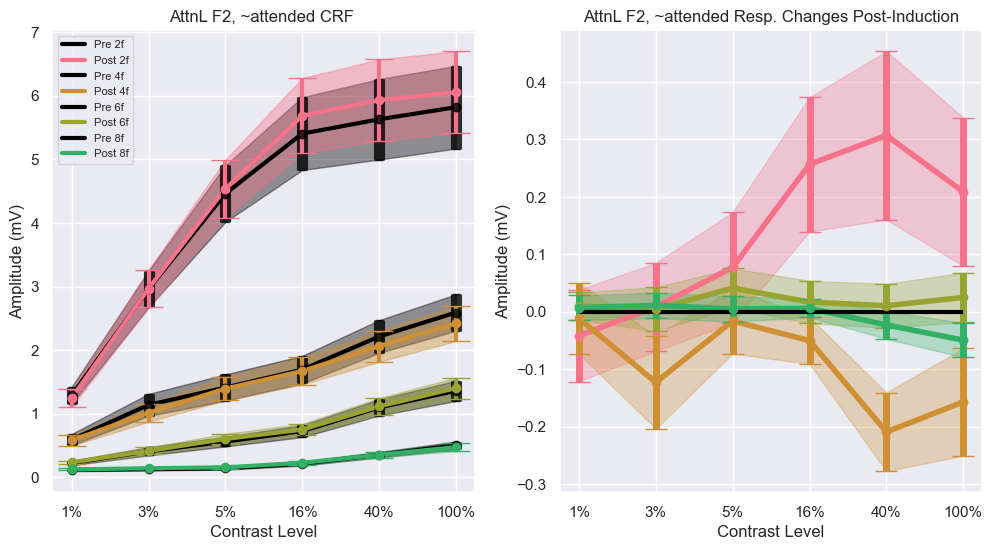

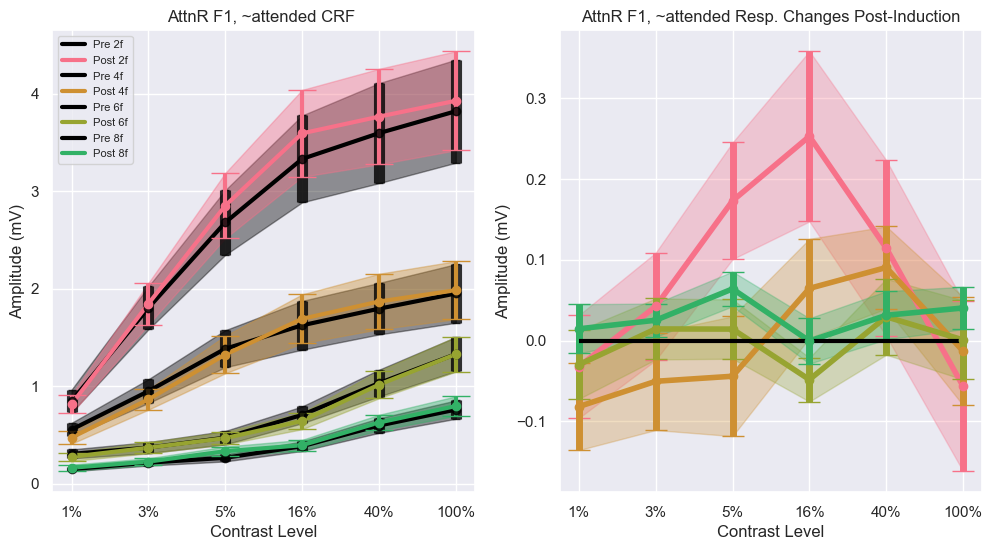

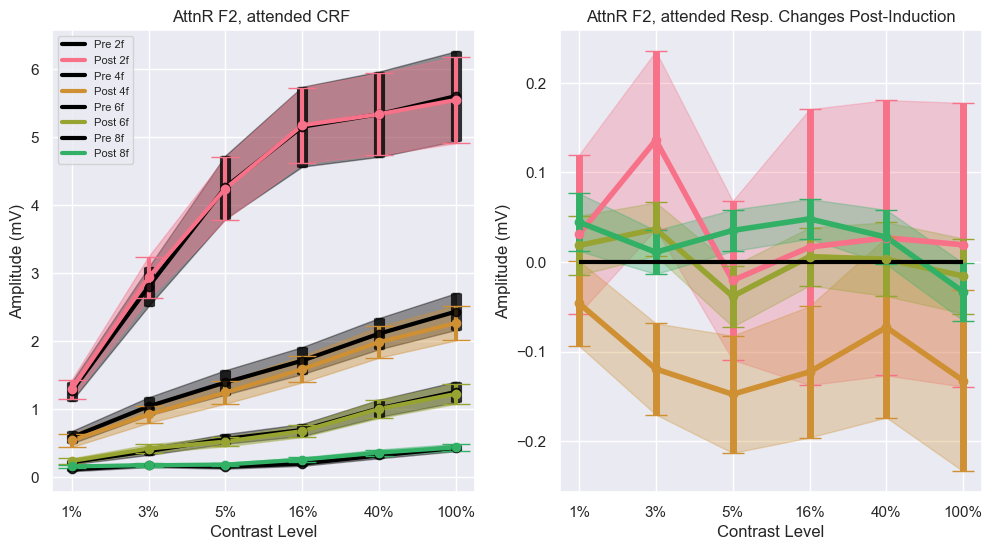

In [10]:
for co in range(NumConds):
     data = CorrectedCRF[co] # 3d [subj x contasts x pre post]
     [ns,nc,nh] = data.shape
     m_pre = np.mean(data[:,:,0],axis = 0,) # 24 array
     m_post = np.mean(data[:,:,1],axis = 0)
     # error bars for post-pre sweep responses
     eb = np.zeros((NumHarms*NumBins,2)) # error bars for pre and post crfs
     for pp in range(2):
          contrastMean = np.mean(data[:,:,pp], axis = 0) # mean across sweeps
          std = np.std(data[:,:,pp],axis = 0) # std across sweeps
          err_bar = std/np.sqrt(ns) # erorr  bar cals
          eb[:,pp] = err_bar # add array to errorbarr array
     ###################################################################
     dd = diff_data[co] # 2d [subj x rpost-pre response differences]
     # error bars for post-pre sweep response differences 
     m_dd = np.mean(dd,axis = 0) # mean of post-pre differences
     std_dd = np.std(dd, axis = 0) # std
     rdeb = std_dd/np.sqrt(ns) # response data error bars
     h_lab = ['2f','4f','6f','8f'] # harmonic labels ! 
     fig,axs = plt.subplots(1,2, figsize = (12,6), sharey = False)
     # plot fig # 1 
     for hi in range(NumHarms): # -1 to run less harmonic data
          s = 0 + (NumBins*hi)
          e = (s + NumBins)
          # plot pre and post crf data
          axs[0].plot(m_pre[s:e], color = 'black', label = f'Pre {h_lab[hi]}', linewidth = 3)
          axs[0].errorbar(np.arange(NumBins),m_pre[s:e],eb[s:e,0],fmt = 'o',color = 'black', linewidth = 3, elinewidth = 8, capsize = 3, alpha = 0.8)
          axs[0].fill_between(np.arange(NumBins), m_pre[s:e] - eb[s:e,0], m_pre[s:e] + eb[s:e,0], color = 'black', alpha=0.4)

          axs[0].plot(m_post[s:e], color = cp1[hi],label = f'Post {h_lab[hi]}', linewidth = 3)
          axs[0].errorbar(np.arange(NumBins),m_post[s:e],eb[s:e,1],fmt = 'o',color = cp1[hi], linewidth = 4, elinewidth = 3, capsize = 10)
          axs[0].fill_between(np.arange(NumBins), m_post[s:e] - eb[s:e,1], m_post[s:e] + eb[s:e,1], color = cp1[hi], alpha=0.4)
     ############ # plot fig # 2 , plot difference data now
          axs[1].plot(m_dd[s:e], color = cp1[hi], linewidth = 4)
          axs[1].errorbar(np.arange(NumBins), m_dd[s:e],rdeb[s:e],fmt = 'o', color = cp1[hi], linewidth = 9, elinewidth = 5, capsize = 8)
          axs[1].fill_between(np.arange(NumBins), m_dd[s:e] - rdeb[s:e], m_dd[s:e] + rdeb[s:e], color = cp1[hi], alpha=0.3)
          if hi == 3: # plt legend once 
               axs[0].legend(loc = 'upper left', fontsize = 8)
     axs[1].hlines(0, xmin = 0, xmax = 5, color = 'black', linewidth = 3)

     axs[0].set_title(f'{data_labels[co]} CRF ')
     axs[0].set_xticks(ticks = np.arange(NumBins),labels = contrast_labs)
     axs[0].set_xlabel('Contrast Level')
     axs[0].set_ylabel('Amplitude (mV)')

     axs[1].set_title(f'{data_labels[co]} Resp. Changes Post-Induction')
     axs[1].set_xticks(ticks = np.arange(NumBins),labels = contrast_labs)
     axs[1].set_xlabel('Contrast Level')
     axs[1].set_ylabel('Amplitude (mV)')

#### New plot for cross-condition performance

In [11]:
cp2 = sns.blend_palette(['green','teal','purple','red'], 5)

Text(0.5, 0.98, 'Average Response Difference Across Conditions')

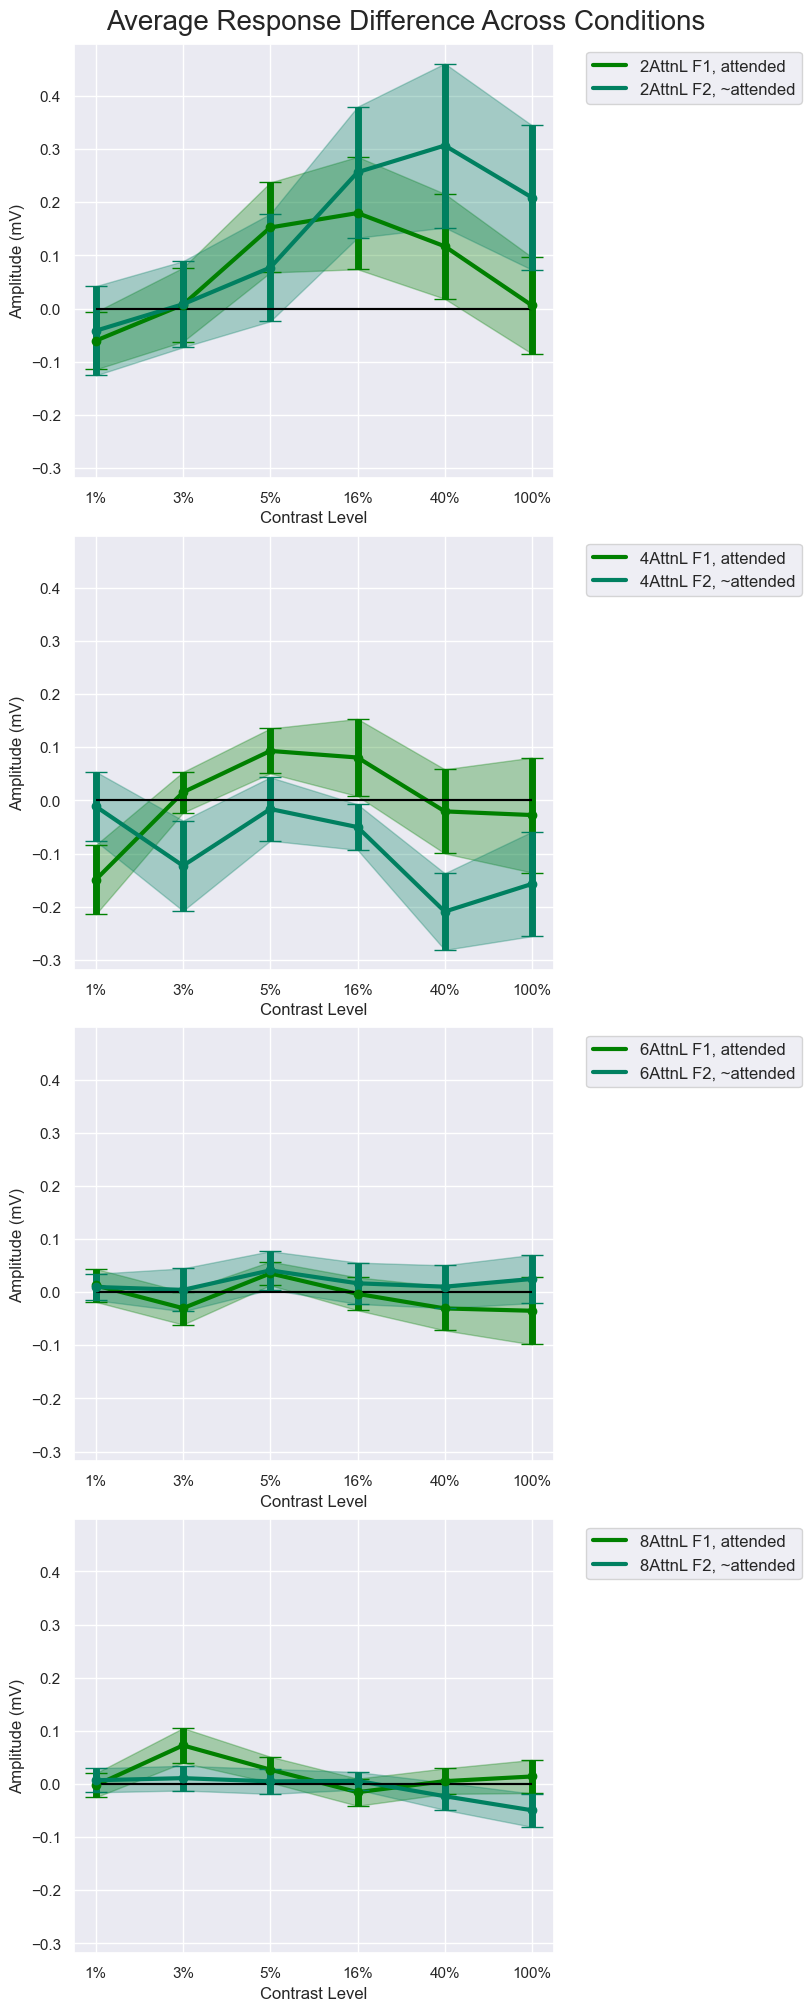

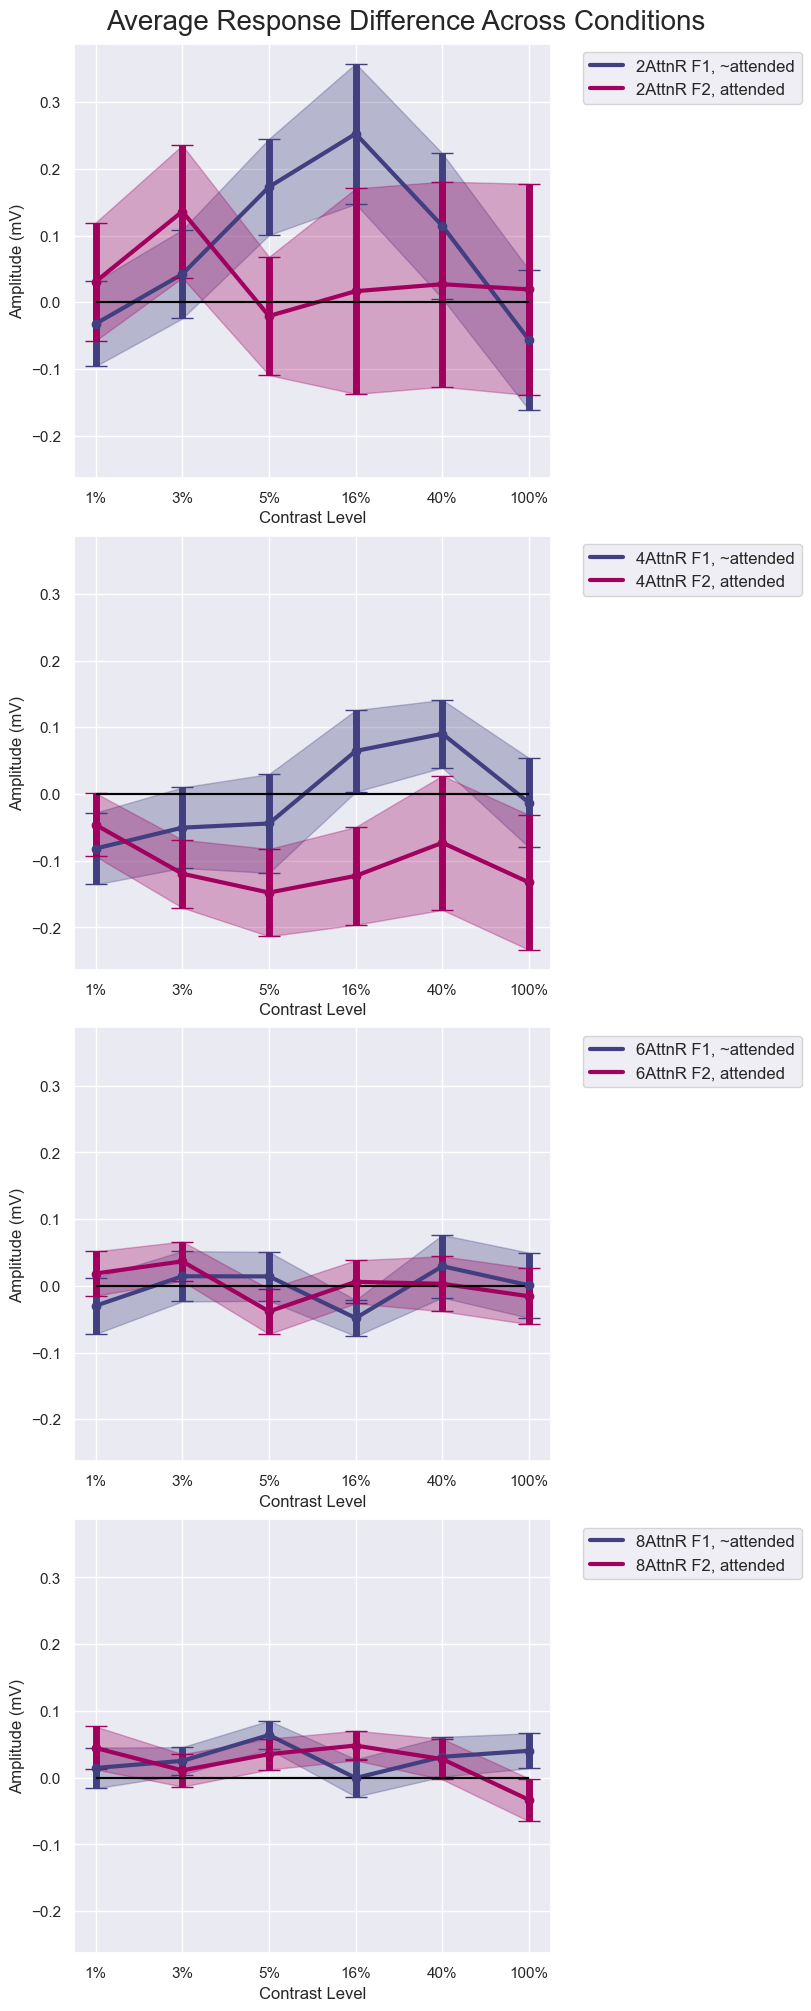

In [12]:
xHarmons = [0,1,2,3]

fig,axs = plt.subplots(4,1,figsize = (8,20),sharey = True, constrained_layout = True)
for xh in range(len(xHarmons)):
    for co in range(NumConds):
            if co == 0 or co == 1:
                dd = diff_data[co] # 2d [subj x rpost-pre response differences]
                cd_mean = np.mean(dd,axis = 0) # co diff means
                # error bars for post-pre sweep response differences 
                m_dd = np.mean(dd,axis = 0) # mean of post-pre differences
                std_dd = np.std(dd, axis = 0) # std
                rdeb = std_dd/np.sqrt(ns) # response data error bars

                s = 0 + (NumBins*xHarmons[xh]) #xHarmons[xh]
                e = (s + NumBins)
                axs[xh].plot(cd_mean[NumBins*xHarmons[xh]:NumBins*(xHarmons[xh]+1)],linewidth = 3,color = cp2[co], label = f'{H_labs[xh]}{data_labels[co]}')
                axs[xh].errorbar(np.arange(NumBins), m_dd[s:e],rdeb[s:e],fmt = 'o', color = cp2[co], linewidth = 9, elinewidth = 5, capsize = 8)
                axs[xh].fill_between(np.arange(NumBins), m_dd[s:e] - rdeb[s:e], m_dd[s:e] + rdeb[s:e], color = cp2[co], alpha=0.3)
                axs[xh].hlines(0,xmin=0, xmax = NumBins-1, color = 'black', linewidth = 1.5)
                axs[xh].legend(loc = 'upper left', fontsize = 12,bbox_to_anchor=(1.05, 1))
                axs[xh].set_xticks(ticks = np.arange(NumBins),labels = contrast_labs)
                axs[xh].set_xlabel('Contrast Level')
                axs[xh].set_ylabel('Amplitude (mV)')
plt.suptitle(f'Average Response Difference Across Conditions',fontsize = 20)


fig,axs = plt.subplots(4,1,figsize = (8,20),sharey = True, constrained_layout = True)
for xh in range(len(xHarmons)):
    for co in range(NumConds):
            if co == 2 or co == 3:
                dd = diff_data[co] # 2d [subj x rpost-pre response differences]
                cd_mean = np.mean(dd,axis = 0) # co diff means
                # error bars for post-pre sweep response differences 
                m_dd = np.mean(dd,axis = 0) # mean of post-pre differences
                std_dd = np.std(dd, axis = 0) # std
                rdeb = std_dd/np.sqrt(ns) # response data error bars

                s = 0 + (NumBins*xHarmons[xh]) #xHarmons[xh]
                e = (s + NumBins)
                axs[xh].plot(cd_mean[NumBins*xHarmons[xh]:NumBins*(xHarmons[xh]+1)],linewidth = 3,color = cp2[co], label = f'{H_labs[xh]}{data_labels[co]}')
                axs[xh].errorbar(np.arange(NumBins), m_dd[s:e],rdeb[s:e],fmt = 'o', color = cp2[co], linewidth = 9, elinewidth = 5, capsize = 8)
                axs[xh].fill_between(np.arange(NumBins), m_dd[s:e] - rdeb[s:e], m_dd[s:e] + rdeb[s:e], color = cp2[co], alpha=0.3)

                axs[xh].hlines(0,xmin=0, xmax = NumBins-1, color = 'black', linewidth = 1.5)
                axs[xh].legend(loc = 'upper left', fontsize = 12,bbox_to_anchor=(1.05, 1))
                axs[xh].set_xticks(ticks = np.arange(NumBins),labels = contrast_labs)
                axs[xh].set_xlabel('Contrast Level')
                axs[xh].set_ylabel('Amplitude (mV)')
plt.suptitle(f'Average Response Difference Across Conditions',fontsize = 20)

Text(0.5, 0.98, 'Average Response Difference Across Conditions')

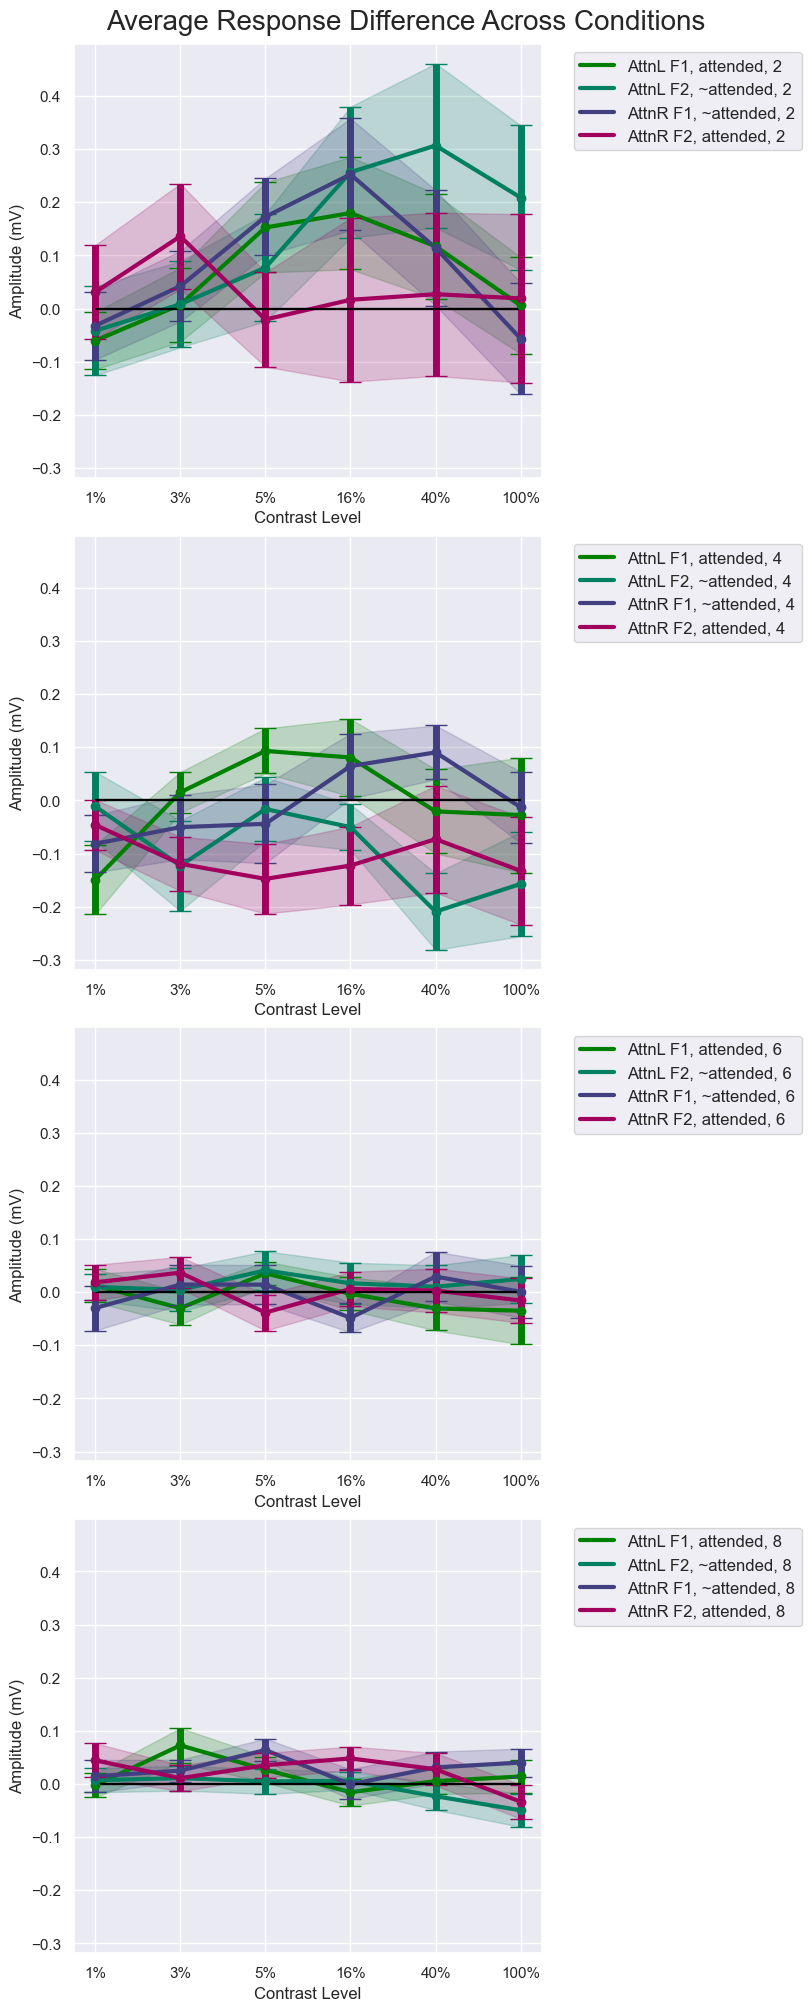

In [13]:
xHarmons = [0,1,2,3]

fig,axs = plt.subplots(4,1,figsize = (8,20),sharey = True, constrained_layout = True)
for xh in range(len(xHarmons)):
    for co in range(NumConds):
            dd = diff_data[co] # 2d [subj x rpost-pre response differences]
            cd_mean = np.mean(dd,axis = 0) # co diff means
            # error bars for post-pre sweep response differences 
            m_dd = np.mean(dd,axis = 0) # mean of post-pre differences
            std_dd = np.std(dd, axis = 0) # std
            rdeb = std_dd/np.sqrt(ns) # response data error bars

            s = 0 + (NumBins*xHarmons[xh]) #xHarmons[xh]
            e = (s + NumBins)
            axs[xh].plot(cd_mean[NumBins*xHarmons[xh]:NumBins*(xHarmons[xh]+1)],linewidth = 3,color = cp2[co], label = f'{data_labels[co]}, {H_labs[xh]}')
            axs[xh].errorbar(np.arange(NumBins), m_dd[s:e],rdeb[s:e],fmt = 'o', color = cp2[co], linewidth = 9, elinewidth = 5, capsize = 8)
            axs[xh].fill_between(np.arange(NumBins), m_dd[s:e] - rdeb[s:e], m_dd[s:e] + rdeb[s:e], color = cp2[co], alpha=0.2)

            axs[xh].hlines(0,xmin=0, xmax = NumBins-1, color = 'black', linewidth = 1.5)
            axs[xh].legend(loc = 'upper left', fontsize = 12,bbox_to_anchor=(1.05, 1))
            axs[xh].set_xticks(ticks = np.arange(NumBins),labels = contrast_labs)
            axs[xh].set_xlabel('Contrast Level')
            axs[xh].set_ylabel('Amplitude (mV)')
plt.suptitle(f'Average Response Difference Across Conditions',fontsize = 20)

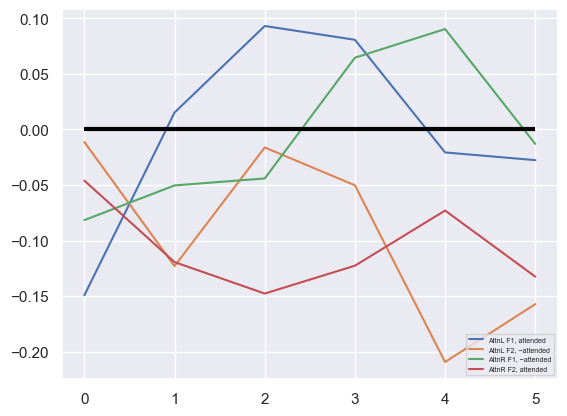

In [14]:
xh = 1
for i in range(NumConds):
    cm = np.mean(diff_data[i],axis = 0)
    plt.plot(cm[0+(xh*NumBins):NumBins+(xh*NumBins)],label = data_labels[i])
plt.hlines(0,xmin = 0,xmax = 5, color = 'black',linewidth =3)
plt.legend(loc = 'lower right',fontsize = 5)

#### Export original crf and fized saturation crf

In [15]:
dictOut = {}

dictOut['crf'] = pp_data # original CRF data
dictOut['resp_diffs'] = diff_data # post - pre data for all conditions

dictOut['mod_crf'] = CorrectedCRF # crf with no supersaturation

dictOut['coSubNames'] = coSubNames
dictOut['ConditionLabels'] = data_labels
dictOut['ContLevs'] = contrast_levels # for plotting x
dictOut['ContLabs'] = contrast_labs # for setting x ticks

In [16]:
# set save data dir 
# Set directory to save NR Data in ..new folder
# SaveDataDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir where files (.pkl, .csv) will be saved
SaveDataDir = 'C:\\plimon\\LTP_analysis\\RCA_F1\\AvgCRFs\\' # set dir where files (.pkl, .csv) will be saved
FileOutName = 'Clean_LTPData_2468F' # make sure this file changes each time you save
######################################################
dnt = datetime.now() # add date and time bc im wreckless when saving ..
fdnt = dnt.strftime("%Y%m%d_%H%M") # set the above as a string ...
FileN = f'{FileOutName}_{fdnt}.pkl' 
MatLabFileN = f'{FileOutName}_{fdnt}.mat'

NewFileNPath = os.path.join(SaveDataDir,FileN)

print('Full New File Dir: ', NewFileNPath)

if not os.path.exists(SaveDataDir):
    os.makedirs(SaveDataDir)
print('Path to Save File is:',SaveDataDir)

Full New File Dir:  C:\plimon\LTP_analysis\RCA_F1\AvgCRFs\Clean_LTPData_2468F_20240404_0954.pkl
Path to Save File is: C:\plimon\LTP_analysis\RCA_F1\AvgCRFs\


In [17]:
saveFile = 'y'

if saveFile == 'y':
 
 with open(NewFileNPath, 'wb') as file:
    pkl.dump(dictOut, file, protocol=pkl.HIGHEST_PROTOCOL)
    # save as .mat file or .csv file to import into matlab 
    
    print('Average CRF Differences Saved! :))')
else:
    print('Did Not Save File! Change file name before switching to y!')

Average CRF Differences Saved! :))
